In [5]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
from scipy.stats import zscore

In [6]:
pd

<module 'pandas' from '/home/basti/.local/share/virtualenvs/teastore_experiments-gXtBjM1O/lib/python3.9/site-packages/pandas/__init__.py'>

In [7]:
DATA_DIR = "data"

In [8]:
experiment_dirs = sorted(glob("data/*"))
experiment_dirs
exp_dir = experiment_dirs[-1]
# exp_dir = "data/2024-06-20_18-00-12"

In [9]:
measurements = glob(exp_dir + "/*/*/*")
measurements

['data/2024-06-22_11-26-02/exp_scale_rampup/dbopt_feature_db-optimization_full/1',
 'data/2024-06-22_11-26-02/exp_scale_rampup/dbopt_feature_db-optimization_full/0',
 'data/2024-06-22_11-26-02/exp_scale_rampup/obs_feature_object-storage_full/1',
 'data/2024-06-22_11-26-02/exp_scale_rampup/obs_feature_object-storage_full/0',
 'data/2024-06-22_11-26-02/exp_scale_rampup/baseline_vanilla_full/1',
 'data/2024-06-22_11-26-02/exp_scale_rampup/baseline_vanilla_full/0',
 'data/2024-06-22_11-26-02/exp_scale_rampup/jvm_jvm-impoove_full/1',
 'data/2024-06-22_11-26-02/exp_scale_rampup/jvm_jvm-impoove_full/0',
 'data/2024-06-22_11-26-02/exp_scale_rampup/norec_feature_norecommendations_full/1',
 'data/2024-06-22_11-26-02/exp_scale_rampup/norec_feature_norecommendations_full/0',
 'data/2024-06-22_11-26-02/exp_scale_rampup/lessrec_feature_lessrecs_full/1',
 'data/2024-06-22_11-26-02/exp_scale_rampup/lessrec_feature_lessrecs_full/0',
 'data/2024-06-22_11-26-02/exp_scale_fixed/dbopt_feature_db-optimizati

In [10]:
def set_experiment_time(
    df, col="collection_time", target="experiment_time", where="run"
):
    missing_time = df[df[col] == "0"]
    print(f"{len(missing_time)} missing times")
    df.drop(missing_time.index, inplace=True)
    df[col] = pd.to_datetime(df[col])

    # the fancy way with different starting times:
    # df["run_starts"] = df.groupby(where)[col].transform("min")
    # df[target] = df[col] - df["run_starts"]

    # one experiment per df:
    df[target] = df[col] - df[col].min()


def drop_outliers(df, z_score_threshold=3):
    data_errors = 0

    common_keys = [
        "wattage_kepler",
        "wattage_scaph",
        # "wattage"
        "cpu_usage",
        "memory_usage",
        "network_usage",
    ]

    for key in common_keys:
        if key in df:
            df[f"{key}_zscore"] = zscore(df[key])

    for key in common_keys:
        outliers = df[df[f"{key}_zscore"].abs() > z_score_threshold].index
        data_errors += len(outliers)
        df = df.drop(outliers)

    print(f"dropped {data_errors} outliers")
    return data_errors


def measurement_file_to_df(file: str, prefix: str, treat=True):
    # no risk, no fun
    (_, pr_time, pr_scale, pr_branch, pr_run, pr_name) = file.split("/")
    pod_df = pd.read_csv(file)
    pod_df["exp_workload"] = pr_scale
    pod_df["exp_branch"] = pr_branch
    pod_df["exp_run_i"] = pr_run
    pod_df["exp_id"] = pr_name.replace(prefix, "").replace(".csv", "")

    pod_df["run"] = "_".join([pr_branch, pr_scale, pr_run])

    if treat:
        drop_outliers(pod_df)
        set_experiment_time(pod_df)

    return pod_df


def get_df_for_prefix(prefix, measurement_dirs, treat=True):
    pod_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    all_pods = pd.concat([measurement_file_to_df(pf, prefix, treat) for pf in pod_files])
    return all_pods

In [11]:
all_pods = get_df_for_prefix("measurements_pod_", measurements)
# set_experiment_time(all_pods)
# drop_outliers(all_pods)

all_nodes = get_df_for_prefix("measurements_node_", measurements)
# set_experiment_time(all_nodes)
# drop_outliers(all_nodes)

display(all_pods.describe())
display(all_nodes.describe())

all_nodes['experiment_time'].dtype

dropped 31 outliers
0 missing times
dropped 36 outliers
0 missing times
dropped 20 outliers
0 missing times
dropped 9 outliers
0 missing times
dropped 29 outliers
0 missing times
dropped 29 outliers
0 missing times
dropped 16 outliers
0 missing times
dropped 15 outliers
0 missing times
dropped 39 outliers
0 missing times
dropped 25 outliers
0 missing times
dropped 13 outliers
0 missing times
dropped 34 outliers
0 missing times
dropped 27 outliers
0 missing times
dropped 29 outliers
0 missing times
dropped 30 outliers
0 missing times
dropped 39 outliers
0 missing times
dropped 19 outliers
0 missing times
dropped 25 outliers
0 missing times
dropped 11 outliers
0 missing times
dropped 21 outliers
0 missing times
dropped 21 outliers
0 missing times
dropped 15 outliers
0 missing times
dropped 24 outliers
0 missing times
dropped 18 outliers
0 missing times
dropped 33 outliers
0 missing times
dropped 26 outliers
0 missing times
dropped 15 outliers
0 missing times
dropped 14 outliers
0 missing

,collection_time,cpu_usage,memory_usage,network_usage,wattage_kepler,wattage_scaph,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
count,17169,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,1.716900e+04,1.716900e+04,1.716900e+04,1.716900e+04,1.716900e+04,17169
mean,2024-06-22 14:28:55.372648704,0.097360,691.633917,0.246687,198.603816,1.768357,-6.000856e-18,4.345447e-18,1.055323e-17,-2.338265e-17,2.483113e-18,0 days 00:02:54.852641388
min,2024-06-22 11:32:22,0.000000,0.000000,0.000000,0.000000,0.000000,-1.227552e+00,-6.239224e-01,-7.980855e-01,-1.781362e+00,-5.883830e-01,0 days 00:00:00
25%,2024-06-22 12:57:00,0.000000,239.931392,0.000000,9.600000,0.000027,-8.648599e-01,-3.402768e-01,-4.465642e-01,-9.481479e-01,-3.561639e-01,0 days 00:01:21
50%,2024-06-22 14:22:15,0.021244,681.680896,0.000786,27.800000,0.002312,-6.599073e-01,-2.513840e-01,-3.135829e-01,3.063794e-02,-2.571174e-01,0 days 00:02:52
75%,2024-06-22 16:00:22,0.068238,1038.135296,0.016846,413.200000,0.049418,1.020802e+00,-8.691646e-02,-1.499853e-02,6.699126e-01,-1.647066e-01,0 days 00:04:23
max,2024-06-22 17:33:20,1.304253,2030.477312,25.941101,1382.300000,3395.931400,4.809048e+00,2.117735e+01,1.051295e+01,5.346853e+00,1.207602e+01,0 days 00:05:55
std,NaN,0.226274,521.455661,1.192038,222.667387,60.120597,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,0 days 00:01:44.072053230


,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,wattage_auxilary,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
count,10218,10218.000000,10218.000000,10218.000000,10218.000000,10218.000000,10218.000000,10218.000000,10218.000000,1.021800e+04,1.021800e+04,1.021800e+04,1.021800e+04,1.021800e+04,10218
mean,2024-06-22 14:32:39.902524928,0.398428,0.181606,1.757077,15.966823,11.071149,0.620753,29.750869,0.136871,-3.824609e-18,-7.344987e-18,-5.563067e-18,-5.058914e-17,-1.564613e-18,0 days 00:02:55.944803288
min,2024-06-22 11:32:22,0.031667,0.094065,0.005331,0.000000,4.000000,0.000000,0.000000,0.000000,-7.929995e-01,-7.154239e-01,-1.125700e+00,-1.978474e+00,-1.525542e+00,0 days 00:00:00
25%,2024-06-22 13:02:13,0.087333,0.128372,0.060910,0.000000,5.000000,0.000000,0.000000,0.000000,-6.252126e-01,-7.048583e-01,-6.750701e-01,-9.713833e-01,-5.497464e-01,0 days 00:01:21
50%,2024-06-22 14:30:33,0.215000,0.196852,0.424262,0.000000,10.500000,0.000000,0.000000,0.000000,-5.426530e-01,-6.856105e-01,-2.374971e-01,3.193570e-01,-3.032435e-01,0 days 00:02:52
75%,2024-06-22 16:03:04,0.395092,0.231856,0.682173,44.000000,16.000000,0.785667,15.393596,0.052995,1.512486e-01,1.242523e+00,1.657006e-01,8.606939e-01,2.265793e-01,0 days 00:04:23
max,2024-06-22 17:33:20,3.389667,0.297075,68.263476,78.000000,19.000000,5.568733,40996.109722,180.430641,3.766811e+00,8.426138e+00,7.675030e+00,1.631183e+00,7.319334e+00,0 days 00:05:55
std,NaN,0.517410,0.056262,5.329451,22.904805,4.890134,0.998880,990.962193,3.893236,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,0 days 00:01:44.332824398


dtype('<m8[ns]')

In [12]:
stats = get_df_for_prefix("teastore_stats.csv", measurements, treat=False)
stats

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
0,GET,/tools.descartes.teastore.webui/,5093,2328,8100.0,24045.121740,1.963614,132873.387934,5509.715492,14.124261,...,132000,132000,133000,133000,133000,exp_scale_rampup,dbopt_feature_db-optimization_full,1,,dbopt_feature_db-optimization_full_exp_scale_r...
1,POST,/tools.descartes.teastore.webui/cartAction,498,498,2900.0,2877.094574,78.472181,7092.825646,0.000000,1.381088,...,5900,6200,7100,7100,7100,exp_scale_rampup,dbopt_feature_db-optimization_full,1,,dbopt_feature_db-optimization_full_exp_scale_r...
2,POST,/tools.descartes.teastore.webui/cartAction?add...,3,0,4400.0,3967.810156,2299.290412,5205.693983,28691.333333,0.008320,...,5200,5200,5200,5200,5200,exp_scale_rampup,dbopt_feature_db-optimization_full,1,,dbopt_feature_db-optimization_full_exp_scale_r...
3,POST,/tools.descartes.teastore.webui/cartAction?add...,2,0,3400.0,4150.540736,3391.426006,4909.655466,27439.500000,0.005547,...,4900,4900,4900,4900,4900,exp_scale_rampup,dbopt_feature_db-optimization_full,1,,dbopt_feature_db-optimization_full_exp_scale_r...
4,POST,/tools.descartes.teastore.webui/cartAction?add...,6,0,3400.0,3728.773586,1104.408812,6665.089855,26970.333333,0.016640,...,6700,6700,6700,6700,6700,exp_scale_rampup,dbopt_feature_db-optimization_full,1,,dbopt_feature_db-optimization_full_exp_scale_r...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,GET,/product,526,0,24.0,68.170016,16.013820,4114.765904,87434.699620,1.477563,...,830,1300,4100,4100,4100,exp_scale_shaped,lessrec_feature_lessrecs_full,0,,lessrec_feature_lessrecs_full_exp_scale_shaped_0
4,GET,/tools.descartes.teastore.webui,34,0,10.0,10.909035,7.077717,17.213193,9018.000000,0.095508,...,17,17,17,17,17,exp_scale_shaped,lessrec_feature_lessrecs_full,0,,lessrec_feature_lessrecs_full_exp_scale_shaped_0
5,GET,/tools.descartes.teastore.webui/cart,64,0,11.0,89.424688,8.382622,2143.985384,9727.000000,0.179779,...,1600,2100,2100,2100,2100,exp_scale_shaped,lessrec_feature_lessrecs_full,0,,lessrec_feature_lessrecs_full_exp_scale_shaped_0
6,GET,/tools.descartes.teastore.webui/order,13,0,11.0,178.944477,7.617828,1525.839911,9018.000000,0.036518,...,1500,1500,1500,1500,1500,exp_scale_shaped,lessrec_feature_lessrecs_full,0,,lessrec_feature_lessrecs_full_exp_scale_shaped_0


In [13]:
agg_stats = stats[stats['Name'] == "Aggregated"]
agg_stats

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
1102,NaN,Aggregated,18792,5277,2700.0,8863.359505,1.963614,132873.387934,32367.172893,52.115279,...,66000,131000,133000,133000,133000,exp_scale_rampup,dbopt_feature_db-optimization_full,1,,dbopt_feature_db-optimization_full_exp_scale_r...
1129,NaN,Aggregated,21517,4154,1900.0,5513.341791,1.898543,50288.716564,39058.489427,59.843823,...,41000,44000,47000,48000,50000,exp_scale_rampup,dbopt_feature_db-optimization_full,0,,dbopt_feature_db-optimization_full_exp_scale_r...
317,NaN,Aggregated,7301,5412,6800.0,23435.289408,1.727764,97640.670504,2108.735105,20.841715,...,96000,97000,98000,98000,98000,exp_scale_rampup,obs_feature_object-storage_full,1,,obs_feature_object-storage_full_exp_scale_ramp...
302,NaN,Aggregated,4631,3262,6200.0,22306.464353,1.844553,131072.668405,2280.332758,13.565083,...,130000,130000,130000,131000,131000,exp_scale_rampup,obs_feature_object-storage_full,0,,obs_feature_object-storage_full_exp_scale_ramp...
1125,NaN,Aggregated,25252,5062,1400.0,6816.552823,1.734958,71039.137376,32934.841319,69.841478,...,61000,63000,67000,68000,71000,exp_scale_rampup,baseline_vanilla_full,1,,baseline_vanilla_full_exp_scale_rampup_1
1116,NaN,Aggregated,22355,6176,3500.0,7777.559225,1.873905,61694.862350,31771.541937,61.783207,...,39000,41000,46000,56000,62000,exp_scale_rampup,baseline_vanilla_full,0,,baseline_vanilla_full_exp_scale_rampup_0
1129,NaN,Aggregated,65669,29,630.0,2591.082602,2.421487,77943.504562,32009.237509,182.525375,...,14000,18000,37000,62000,78000,exp_scale_rampup,jvm_jvm-impoove_full,1,,jvm_jvm-impoove_full_exp_scale_rampup_1
1130,NaN,Aggregated,66875,28,690.0,2530.682041,1.776000,61827.690083,31896.241181,185.926324,...,12000,14000,35000,57000,62000,exp_scale_rampup,jvm_jvm-impoove_full,0,,jvm_jvm-impoove_full_exp_scale_rampup_0
1131,NaN,Aggregated,24208,4659,1300.0,5138.085683,1.790921,65952.696922,30234.792094,69.691691,...,41000,47000,66000,66000,66000,exp_scale_rampup,norec_feature_norecommendations_full,1,,norec_feature_norecommendations_full_exp_scale...
1133,NaN,Aggregated,65318,2439,1200.0,2415.768248,2.278033,105861.738399,40311.096068,181.218101,...,20000,27000,81000,102000,106000,exp_scale_rampup,norec_feature_norecommendations_full,0,,norec_feature_norecommendations_full_exp_scale...


In [14]:
# all_nodes.join(agg_stats, on="run", how="right")
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,ise-knode6,2024-06-22 11:54:09,2024-06-22 11:54:09,0.203333,0.094507,0.487401,44,17,2.183522,15.393993,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,1.626559,1.030162,-0.574114,-1.548052,-0.298386,0 days 00:00:00
1,ise-knode1,2024-06-22 11:54:09,2024-06-22 11:54:09,0.548073,0.199535,0.640499,0,16,1.629600,1.651583,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,1.016263,-0.518270,-0.008625,0.321014,-0.277290,0 days 00:00:00
2,ise-knode2,2024-06-22 11:54:09,2024-06-22 11:54:09,0.040333,0.213561,0.005718,0,4,0.000000,0.000000,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.779186,-0.704363,-0.841489,0.570628,-0.364759,0 days 00:00:00
3,sm-gpu,2024-06-22 11:54:09,2024-06-22 11:54:09,0.576333,0.121503,0.070344,61,12,0.921867,20.475302,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,0.236502,1.602701,0.037731,-1.067645,-0.355854,0 days 00:00:00
4,ise-kmaster,2024-06-22 11:54:09,2024-06-22 11:54:09,0.254042,0.240034,0.330350,0,10,0.000000,0.000000,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.779186,-0.704363,-0.490934,1.041741,-0.320026,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,ise-knode1,2024-06-22 12:38:49,2024-06-22 12:38:49,0.339667,0.228962,1.504634,0,15,0.086633,0.119634,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.531236,-0.692934,0.170751,0.826708,-0.072251,0 days 00:05:43
200,ise-knode2,2024-06-22 12:38:49,2024-06-22 12:38:49,0.049000,0.216584,0.828547,0,5,0.000000,0.000000,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.637413,-0.708185,-0.782565,0.602973,-0.448821,0 days 00:05:43
201,sm-gpu,2024-06-22 12:38:49,2024-06-22 12:38:49,0.223667,0.212945,1.069160,48,14,0.183800,15.713655,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.412149,1.294890,-0.209701,0.537192,-0.314803,0 days 00:05:43
202,ise-kmaster,2024-06-22 12:38:49,2024-06-22 12:38:49,0.208667,0.246368,0.357260,0,10,0.000000,0.000000,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.637413,-0.708185,-0.258897,1.141327,-0.711320,0 days 00:05:43


In [15]:
all_pods.groupby(all_pods['name'])[['cpu_usage', 'memory_usage', 'wattage_kepler', 'wattage_scaph']].describe(percentiles=[])

cpu_usage                                               \
                           count      mean       std  min       50%       max   
name                                                                            
loadgenerator             1701.0  0.084704  0.174062  0.0  0.025429  1.002097   
teastore-auth-0           1703.0  0.091380  0.130969  0.0  0.043213  0.589186   
teastore-auth-1            961.0  0.077917  0.148866  0.0  0.000000  0.586826   
teastore-auth-2            484.0  0.158255  0.246079  0.0  0.000000  0.586040   
teastore-db-0             1703.0  0.004224  0.010458  0.0  0.001449  0.111804   
teastore-image-0          1703.0  0.097425  0.169317  0.0  0.032843  1.220255   
teastore-image-1           398.0  0.062437  0.154519  0.0  0.000000  1.048595   
teastore-persistence-0    1703.0  0.098927  0.156590  0.0  0.033800  0.914560   
teastore-recommender-0    1703.0  0.053967  0.063279  0.0  0.040630  0.779451   
teastore-registry-0       1703.0  0.017425  0.016159  0.0  0.016806  0.155703   
teastore-webui-0          1703.0  0.254575  0.413693  0.0  0.052124  1.302731   
teastore-webui-1          1266.0  0.147102  0.345214  0.0  0.000000  1.304253   
teastore-webui-2           438.0  0.257107  0.501815  0.0  0.000000  1.303064   

                       memory_usage                                       ...  \
                              count         mean         std         min  ...   
name                                                                      ...   
loadgenerator                1701.0    92.621926   66.236817    3.694592  ...   
teastore-auth-0              1703.0   814.916893  344.351789    3.137536  ...   
teastore-auth-1               961.0   796.613444  308.106805    0.000000  ...   
teastore-auth-2               484.0   672.613507  346.450863    0.000000  ...   
teastore-db-0                1703.0   102.852809    4.562268   94.509056  ...   
teastore-image-0             1703.0   899.697829  573.447173    3.190784  ...   
teastore-image-1              398.0  1303.704082  338.057797    0.000000  ...   
teastore-persistence-0       1703.0   749.640828  190.449983  366.784512  ...   
teastore-recommender-0       1703.0   771.846290  280.030433    3.133440  ...   
teastore-registry-0          1703.0   277.954347   31.614158  191.496192  ...   
teastore-webui-0             1703.0  1236.916713  491.999769    3.506176  ...   
teastore-webui-1             1266.0  1196.514607  545.340014    0.000000  ...   
teastore-webui-2              438.0   744.966822  526.313013    0.000000  ...   

                       wattage_kepler                                \
                                  std  min         50%          max   
name                                                                  
loadgenerator                0.000000  0.0    0.000000     0.000000   
teastore-auth-0            228.682760  0.0   40.400000   717.800000   
teastore-auth-1            235.580416  0.0  382.200000   688.600000   
teastore-auth-2            176.900383  0.0  335.132973   377.800000   
teastore-db-0              136.495685  0.0  192.400000  1382.300000   
teastore-image-0           229.805572  0.0   51.800000   720.400000   
teastore-image-1           235.732734  0.0  384.800000   705.600000   
teastore-persistence-0     225.235112  0.0  402.600000   720.400000   
teastore-recommender-0     211.271721  0.0   16.600000   665.400000   
teastore-registry-0        216.911751  0.0  415.400000   717.800000   
teastore-webui-0           219.050642  0.0   28.200000   720.400000   
teastore-webui-1           230.963743  0.0   14.000000   703.200000   
teastore-webui-2           178.092772  0.0    0.000000   900.640171   

                       wattage_scaph                                       \
                               count      mean         std  min       50%   
name                                                                        
loadgenerator                 1701.0  0.000000    0.000000  0

<Axes: xlabel='experiment_time', ylabel='wattage_scaph'>

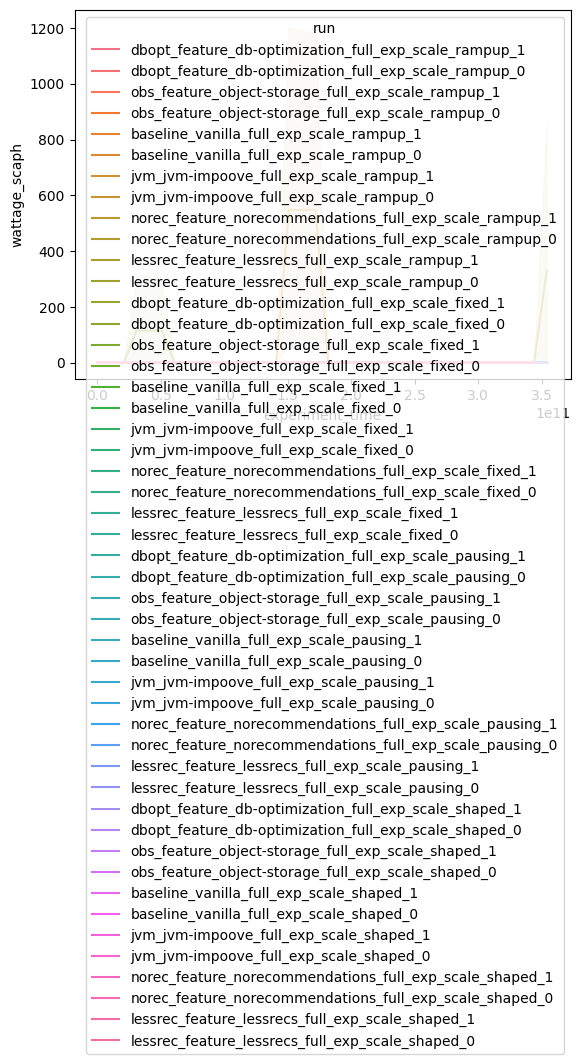

In [16]:
sns.lineplot(data=all_pods, x="experiment_time", y="wattage_scaph", hue="run")

In [17]:
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,ise-knode6,2024-06-22 11:54:09,2024-06-22 11:54:09,0.203333,0.094507,0.487401,44,17,2.183522,15.393993,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,1.626559,1.030162,-0.574114,-1.548052,-0.298386,0 days 00:00:00
1,ise-knode1,2024-06-22 11:54:09,2024-06-22 11:54:09,0.548073,0.199535,0.640499,0,16,1.629600,1.651583,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,1.016263,-0.518270,-0.008625,0.321014,-0.277290,0 days 00:00:00
2,ise-knode2,2024-06-22 11:54:09,2024-06-22 11:54:09,0.040333,0.213561,0.005718,0,4,0.000000,0.000000,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.779186,-0.704363,-0.841489,0.570628,-0.364759,0 days 00:00:00
3,sm-gpu,2024-06-22 11:54:09,2024-06-22 11:54:09,0.576333,0.121503,0.070344,61,12,0.921867,20.475302,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,0.236502,1.602701,0.037731,-1.067645,-0.355854,0 days 00:00:00
4,ise-kmaster,2024-06-22 11:54:09,2024-06-22 11:54:09,0.254042,0.240034,0.330350,0,10,0.000000,0.000000,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.779186,-0.704363,-0.490934,1.041741,-0.320026,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,ise-knode1,2024-06-22 12:38:49,2024-06-22 12:38:49,0.339667,0.228962,1.504634,0,15,0.086633,0.119634,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.531236,-0.692934,0.170751,0.826708,-0.072251,0 days 00:05:43
200,ise-knode2,2024-06-22 12:38:49,2024-06-22 12:38:49,0.049000,0.216584,0.828547,0,5,0.000000,0.000000,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.637413,-0.708185,-0.782565,0.602973,-0.448821,0 days 00:05:43
201,sm-gpu,2024-06-22 12:38:49,2024-06-22 12:38:49,0.223667,0.212945,1.069160,48,14,0.183800,15.713655,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.412149,1.294890,-0.209701,0.537192,-0.314803,0 days 00:05:43
202,ise-kmaster,2024-06-22 12:38:49,2024-06-22 12:38:49,0.208667,0.246368,0.357260,0,10,0.000000,0.000000,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.637413,-0.708185,-0.258897,1.141327,-0.711320,0 days 00:05:43


In [18]:
all_nodes.groupby(['exp_workload', 'exp_branch', 'run']).describe()

collection_time  \
                                                                                                                    count   
exp_workload      exp_branch                           run                                                                  
exp_scale_fixed   baseline_vanilla_full                baseline_vanilla_full_exp_scale_fixed_0                        216   
                                                       baseline_vanilla_full_exp_scale_fixed_1                        216   
                  dbopt_feature_db-optimization_full   dbopt_feature_db-optimization_full_exp_scale_fi...             216   
                                                       dbopt_feature_db-optimization_full_exp_scale_fi...             216   
                  jvm_jvm-impoove_full                 jvm_jvm-impoove_full_exp_scale_fixed_0                         204   
                                                       jvm_jvm-impoove_full_exp_scale_fixed_1                         210   
                  lessrec_feature_lessrecs_full        lessrec_feature_lessrecs_full_exp_scale_fixed_0                210   
                                                       lessrec_feature_lessrecs_full_exp_scale_fixed_1                210   
                  norec_feature_norecommendations_full norec_feature_norecommendations_full_exp_scale_...             216   
                                                       norec_feature_norecommendations_full_exp_scale_...             216   
                  obs_feature_object-storage_full      obs_feature_object-storage_full_exp_scale_fixed_0              216   
                                                       obs_feature_object-storage_full_exp_scale_fixed_1              216   
exp_scale_pausing baseline_vanilla_full                baseline_vanilla_full_exp_scale_pausing_0                      216   
                                                       baseline_vanilla_full_exp_scale_pausing_1                      216   
                  dbopt_feature_db-optimization_full   dbopt_feature_db-optimization_full_exp_scale_pa...             210   
                                                       dbopt_feature_db-optimization_full_exp_scale_pa...             216   
                  jvm_jvm-impoove_full                 jvm_jvm-impoove_full_exp_scale_pausing_0                       216   
                                                       jvm_jvm-impoove_full_exp_scale_pausing_1                       204   
                  lessrec_feature_lessrecs_full        lessrec_feature_lessrecs_full_exp_scale_pausing_0              216   
                                                       lessrec_feature_lessrecs_full_exp_scale_pausing_1              216   
                  norec_feature_norecommendations_full norec_feature_norecommendations_full_exp_scale_...             216   
                                                       norec_feature_norecommendations_full_exp_scale_...             216   
                  obs_feature_object-storage_full      obs_feature_object-storage_full_exp_scale_pausi...             216   
                                                       obs_feature_object-storage_full_exp_scale_pausi...             216   
exp_scale_rampup  baseline_vanilla_full                baseline_vanilla_full_exp_scale_rampup_0                       216   
                                                       baseline_vanilla_full_exp_scale_rampup_1                       210   
                  dbopt_feature_db-optimization_full   dbopt_feature_db-optimization_full_exp_scale_ra...             216   
                                                       dbopt_feature_db-optimization_full_exp_scale_ra...             216   
                  jvm_jvm-impoove_full                 jvm_jvm-impoove_full_exp_scale_rampup_0                        210   
                                                       jvm_jvm-impoove_full_exp_scale_rampup_1            

<Axes: xlabel='experiment_time', ylabel='cpu_usage'>

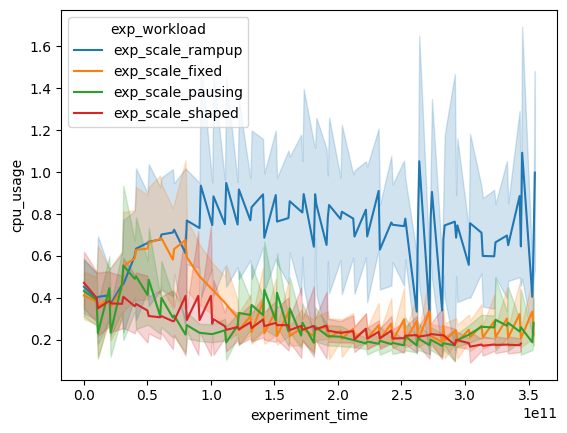

In [19]:
sns.lineplot(data=all_nodes, x="experiment_time", y="cpu_usage", hue="exp_workload")

<Axes: xlabel='experiment_time', ylabel='memory_usage'>

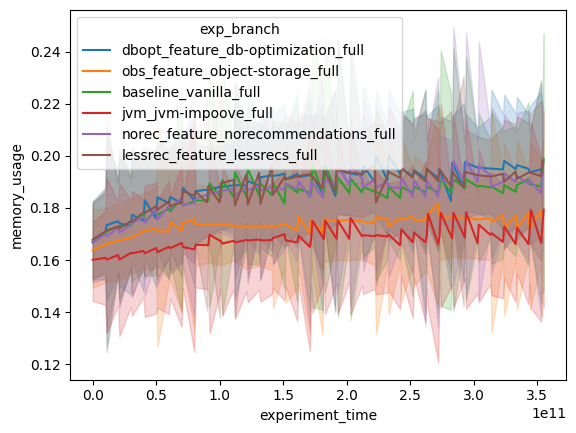

In [20]:
sns.lineplot(data=all_nodes, x="experiment_time", y="memory_usage", hue="exp_branch")

<Axes: xlabel='experiment_time', ylabel='memory_usage'>

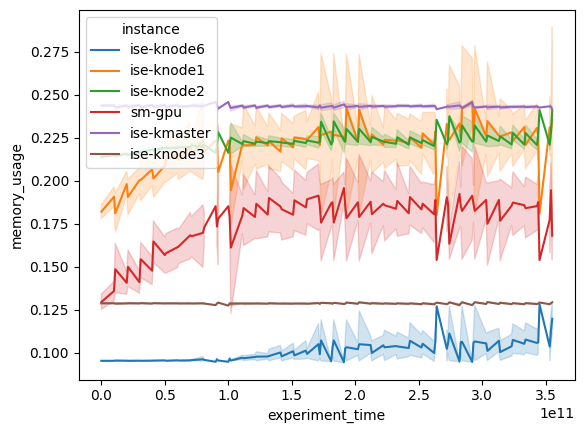

In [21]:
sns.lineplot(data=all_nodes, x="experiment_time", y="memory_usage", hue="instance")

In [22]:
wattage_fields = ["wattage", "wattage_kepler", "wattage_scaph", "wattage_auxilary"]
wattage_df = pd.melt(frame=all_nodes, id_vars=("exp_workload", "exp_branch", "experiment_time"), value_vars=wattage_fields)

display(wattage_df)
# sns.pairplot(data=wattage_df, x="experiment_time", y="value", hue="variable")


,exp_workload,exp_branch,experiment_time,variable,value
0,exp_scale_rampup,dbopt_feature_db-optimization_full,0 days 00:00:00,wattage,44.000000
1,exp_scale_rampup,dbopt_feature_db-optimization_full,0 days 00:00:00,wattage,0.000000
2,exp_scale_rampup,dbopt_feature_db-optimization_full,0 days 00:00:00,wattage,0.000000
3,exp_scale_rampup,dbopt_feature_db-optimization_full,0 days 00:00:00,wattage,61.000000
4,exp_scale_rampup,dbopt_feature_db-optimization_full,0 days 00:00:00,wattage,0.000000
...,...,...,...,...,...
40867,exp_scale_shaped,lessrec_feature_lessrecs_full,0 days 00:05:43,wattage_auxilary,0.000380
40868,exp_scale_shaped,lessrec_feature_lessrecs_full,0 days 00:05:43,wattage_auxilary,0.000000
40869,exp_scale_shaped,lessrec_feature_lessrecs_full,0 days 00:05:43,wattage_auxilary,0.054185
40870,exp_scale_shaped,lessrec_feature_lessrecs_full,0 days 00:05:43,wattage_auxilary,0.000000


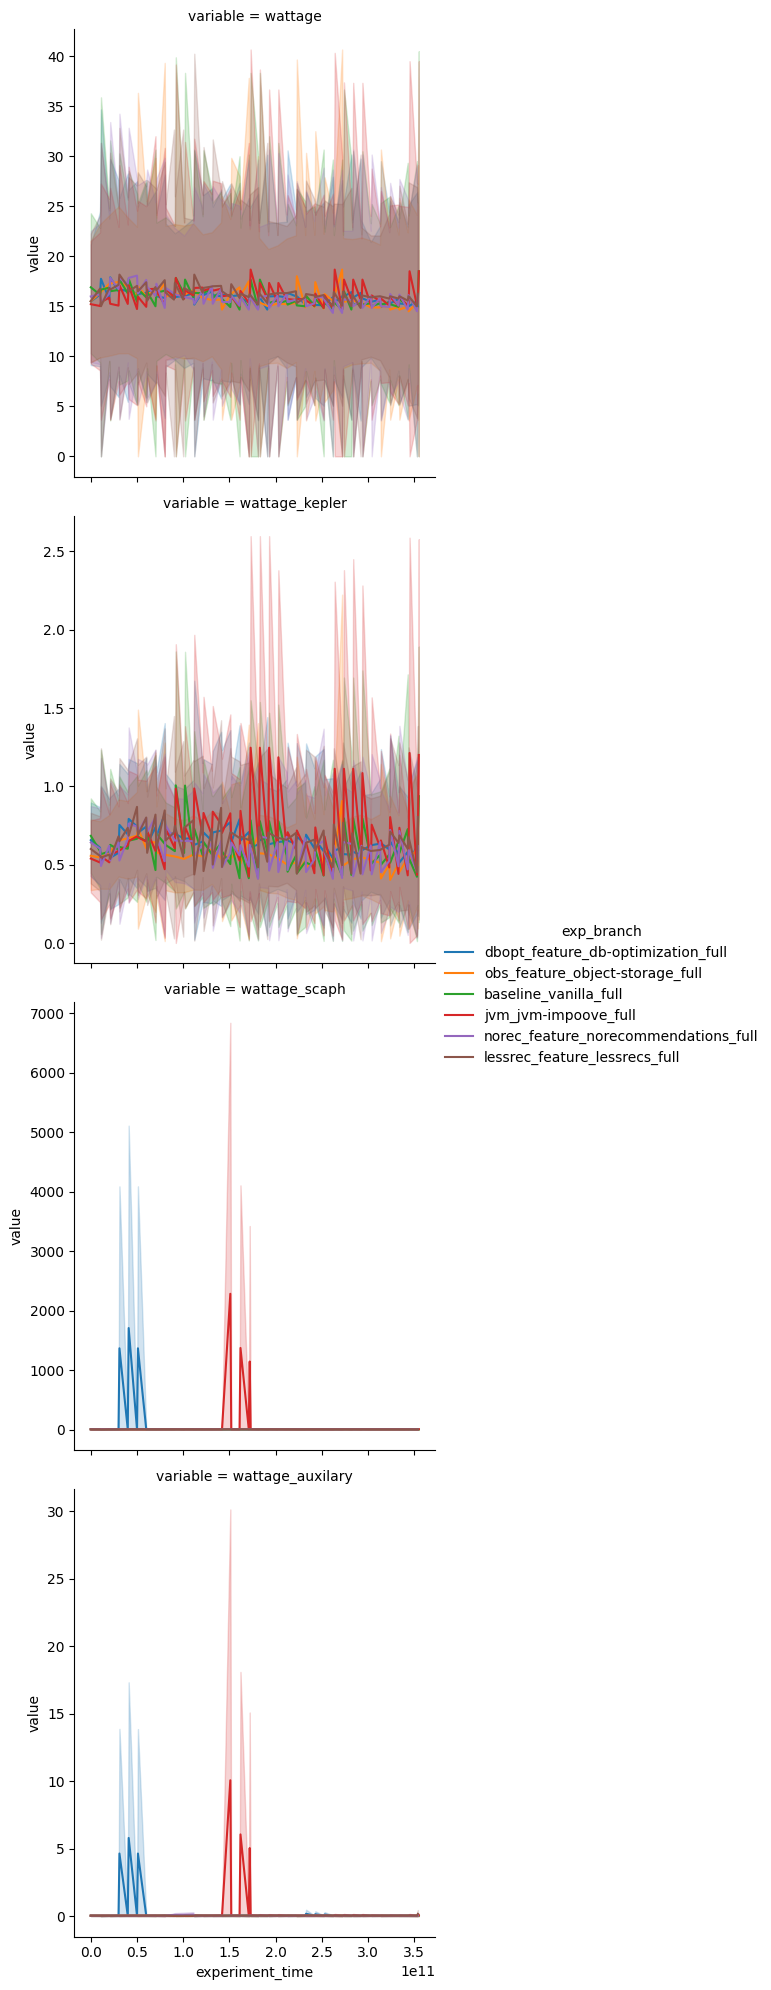

In [23]:
sns.relplot(
    data=wattage_df,
    kind="line",
    x="experiment_time",
    y="value",
    row="variable",
    # row="exp_workload",
    hue="exp_branch",
    facet_kws=dict(sharey=False),
)

In [24]:
all_nodes.dtypes

instance                          object
observation_time                  object
collection_time           datetime64[ns]
cpu_usage                        float64
memory_usage                     float64
network_usage                    float64
wattage                            int64
num_processes                      int64
wattage_kepler                   float64
wattage_scaph                    float64
wattage_auxilary                 float64
exp_workload                      object
exp_branch                        object
exp_run_i                         object
exp_id                            object
run                               object
wattage_kepler_zscore            float64
wattage_scaph_zscore             float64
cpu_usage_zscore                 float64
memory_usage_zscore              float64
network_usage_zscore             float64
experiment_time          timedelta64[ns]
dtype: object

In [25]:
# meaningful aggregations

display(all_pods)
display(agg_stats)
pod_stats = all_pods.groupby(["run"])[["wattage_scaph","wattage_kepler","cpu_usage"]].mean()
pod_stats


,collection_time,observation_time,name,namespace,cpu_usage,memory_usage,network_usage,instance,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,2024-06-22 11:54:09,2024-06-22 11:54:09,loadgenerator,tea-bench,0.000000,136.980480,0.000000,unknown,0.0,0.000000,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.728620,-0.298627,-0.449325,-1.483750,-0.247643,0 days 00:00:00
1,2024-06-22 11:54:09,2024-06-22 11:54:09,teastore-webui-1,tea-bench,0.000000,1316.397056,0.000000,unknown,0.0,0.000000,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.728620,-0.298627,-0.449325,1.078725,-0.247643,0 days 00:00:00
2,2024-06-22 11:54:09,2024-06-22 11:54:09,teastore-recommender-0,tea-bench,0.177291,777.740288,0.000621,ise-knode1,57.0,0.099662,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.508459,0.010935,0.196916,-0.091595,-0.247270,0 days 00:00:00
3,2024-06-22 11:54:09,2024-06-22 11:54:09,teastore-registry-0,tea-bench,0.024603,269.477888,0.002847,sm-gpu,489.4,0.030791,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,1.161676,-0.202987,-0.359645,-1.195878,-0.245933,0 days 00:00:00
4,2024-06-22 11:54:09,2024-06-22 11:54:09,teastore-image-1,tea-bench,0.000000,1398.235136,0.000000,unknown,0.0,0.000000,...,dbopt_feature_db-optimization_full,1,22_06_2024_11_53,dbopt_feature_db-optimization_full_exp_scale_r...,-0.728620,-0.298627,-0.449325,1.256532,-0.247643,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2024-06-22 12:38:49,2024-06-22 12:38:49,teastore-persistence-0,tea-bench,0.000000,806.113280,0.000000,ise-knode1,10.0,0.000340,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.948130,-0.384356,-0.507074,0.335915,-0.588383,0 days 00:05:43
312,2024-06-22 12:38:49,2024-06-22 12:38:49,teastore-db-0,tea-bench,0.000000,104.034304,0.004280,sm-gpu,197.3,0.001311,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.040244,-0.377704,-0.507074,-0.901920,-0.578262,0 days 00:05:43
313,2024-06-22 12:38:49,2024-06-22 12:38:49,teastore-webui-0,tea-bench,0.045019,1494.081536,0.283099,ise-knode1,10.0,0.000345,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,-0.948130,-0.384322,-0.185875,1.548871,0.081022,0 days 00:05:43
314,2024-06-22 12:38:49,2024-06-22 12:38:49,teastore-image-0,tea-bench,0.000000,1108.287488,0.137826,sm-gpu,394.6,0.056807,...,lessrec_feature_lessrecs_full,0,22_06_2024_12_32,lessrec_feature_lessrecs_full_exp_scale_shaped_0,0.916113,0.002350,-0.507074,0.868678,-0.262484,0 days 00:05:43


,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
1102,NaN,Aggregated,18792,5277,2700.0,8863.359505,1.963614,132873.387934,32367.172893,52.115279,...,66000,131000,133000,133000,133000,exp_scale_rampup,dbopt_feature_db-optimization_full,1,,dbopt_feature_db-optimization_full_exp_scale_r...
1129,NaN,Aggregated,21517,4154,1900.0,5513.341791,1.898543,50288.716564,39058.489427,59.843823,...,41000,44000,47000,48000,50000,exp_scale_rampup,dbopt_feature_db-optimization_full,0,,dbopt_feature_db-optimization_full_exp_scale_r...
317,NaN,Aggregated,7301,5412,6800.0,23435.289408,1.727764,97640.670504,2108.735105,20.841715,...,96000,97000,98000,98000,98000,exp_scale_rampup,obs_feature_object-storage_full,1,,obs_feature_object-storage_full_exp_scale_ramp...
302,NaN,Aggregated,4631,3262,6200.0,22306.464353,1.844553,131072.668405,2280.332758,13.565083,...,130000,130000,130000,131000,131000,exp_scale_rampup,obs_feature_object-storage_full,0,,obs_feature_object-storage_full_exp_scale_ramp...
1125,NaN,Aggregated,25252,5062,1400.0,6816.552823,1.734958,71039.137376,32934.841319,69.841478,...,61000,63000,67000,68000,71000,exp_scale_rampup,baseline_vanilla_full,1,,baseline_vanilla_full_exp_scale_rampup_1
1116,NaN,Aggregated,22355,6176,3500.0,7777.559225,1.873905,61694.862350,31771.541937,61.783207,...,39000,41000,46000,56000,62000,exp_scale_rampup,baseline_vanilla_full,0,,baseline_vanilla_full_exp_scale_rampup_0
1129,NaN,Aggregated,65669,29,630.0,2591.082602,2.421487,77943.504562,32009.237509,182.525375,...,14000,18000,37000,62000,78000,exp_scale_rampup,jvm_jvm-impoove_full,1,,jvm_jvm-impoove_full_exp_scale_rampup_1
1130,NaN,Aggregated,66875,28,690.0,2530.682041,1.776000,61827.690083,31896.241181,185.926324,...,12000,14000,35000,57000,62000,exp_scale_rampup,jvm_jvm-impoove_full,0,,jvm_jvm-impoove_full_exp_scale_rampup_0
1131,NaN,Aggregated,24208,4659,1300.0,5138.085683,1.790921,65952.696922,30234.792094,69.691691,...,41000,47000,66000,66000,66000,exp_scale_rampup,norec_feature_norecommendations_full,1,,norec_feature_norecommendations_full_exp_scale...
1133,NaN,Aggregated,65318,2439,1200.0,2415.768248,2.278033,105861.738399,40311.096068,181.218101,...,20000,27000,81000,102000,106000,exp_scale_rampup,norec_feature_norecommendations_full,0,,norec_feature_norecommendations_full_exp_scale...


,wattage_scaph,wattage_kepler,cpu_usage
run,,,
baseline_vanilla_full_exp_scale_fixed_0,0.068306,217.852907,0.071197
baseline_vanilla_full_exp_scale_fixed_1,0.082094,192.585614,0.067678
baseline_vanilla_full_exp_scale_pausing_0,0.063782,192.391758,0.053189
baseline_vanilla_full_exp_scale_pausing_1,0.076973,168.381693,0.068752
baseline_vanilla_full_exp_scale_rampup_0,0.173995,276.615607,0.155742
baseline_vanilla_full_exp_scale_rampup_1,0.133164,184.564021,0.143373
baseline_vanilla_full_exp_scale_shaped_0,0.035625,185.818557,0.067018
baseline_vanilla_full_exp_scale_shaped_1,0.056622,245.138235,0.062247
dbopt_feature_db-optimization_full_exp_scale_fixed_0,0.128332,180.802386,0.104962


In [26]:
merged_stats = pd.merge(left=pod_stats, right=agg_stats, on="run")
merged_stats

,run,wattage_scaph,wattage_kepler,cpu_usage,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,...,95%,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id
0,baseline_vanilla_full_exp_scale_fixed_0,0.068306,217.852907,0.071197,NaN,Aggregated,2983,33,610.0,926.117290,...,2200,5200,7700,12000,13000,13000,exp_scale_fixed,baseline_vanilla_full,0,
1,baseline_vanilla_full_exp_scale_fixed_1,0.082094,192.585614,0.067678,NaN,Aggregated,2778,15,190.0,251.933948,...,490,1400,2300,5100,7100,7100,exp_scale_fixed,baseline_vanilla_full,1,
2,baseline_vanilla_full_exp_scale_pausing_0,0.063782,192.391758,0.053189,NaN,Aggregated,834,7,100.0,442.453243,...,3000,3900,4100,8600,8600,8600,exp_scale_pausing,baseline_vanilla_full,0,
3,baseline_vanilla_full_exp_scale_pausing_1,0.076973,168.381693,0.068752,NaN,Aggregated,646,41,280.0,1503.489535,...,5300,13000,24000,29000,29000,29000,exp_scale_pausing,baseline_vanilla_full,1,
4,baseline_vanilla_full_exp_scale_rampup_0,0.173995,276.615607,0.155742,NaN,Aggregated,22355,6176,3500.0,7777.559225,...,30000,39000,41000,46000,56000,62000,exp_scale_rampup,baseline_vanilla_full,0,
5,baseline_vanilla_full_exp_scale_rampup_1,0.133164,184.564021,0.143373,NaN,Aggregated,25252,5062,1400.0,6816.552823,...,47000,61000,63000,67000,68000,71000,exp_scale_rampup,baseline_vanilla_full,1,
6,baseline_vanilla_full_exp_scale_shaped_0,0.035625,185.818557,0.067018,NaN,Aggregated,2815,1,17.0,89.870481,...,58,150,2000,12000,12000,12000,exp_scale_shaped,baseline_vanilla_full,0,
7,baseline_vanilla_full_exp_scale_shaped_1,0.056622,245.138235,0.062247,NaN,Aggregated,2815,2,16.0,98.302838,...,47,190,2400,13000,14000,14000,exp_scale_shaped,baseline_vanilla_full,1,
8,dbopt_feature_db-optimization_full_exp_scale_f...,0.128332,180.802386,0.104962,NaN,Aggregated,3007,29,510.0,975.475841,...,2300,6300,8500,13000,19000,19000,exp_scale_fixed,dbopt_feature_db-optimization_full,0,
9,dbopt_feature_db-optimization_full_exp_scale_f...,10.268200,191.320906,0.057579,NaN,Aggregated,2695,2,210.0,305.973081,...,530,820,2800,6700,7200,7200,exp_scale_fixed,dbopt_feature_db-optimization_full,1,


In [27]:
merged_stats['scaph_per_rq'] = merged_stats['wattage_scaph'] / merged_stats['Request Count']
merged_stats['kepler_per_rq'] = merged_stats['wattage_kepler'] / merged_stats['Request Count']

merged_stats

,run,wattage_scaph,wattage_kepler,cpu_usage,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,...,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,scaph_per_rq,kepler_per_rq
0,baseline_vanilla_full_exp_scale_fixed_0,0.068306,217.852907,0.071197,NaN,Aggregated,2983,33,610.0,926.117290,...,7700,12000,13000,13000,exp_scale_fixed,baseline_vanilla_full,0,,0.000023,0.073031
1,baseline_vanilla_full_exp_scale_fixed_1,0.082094,192.585614,0.067678,NaN,Aggregated,2778,15,190.0,251.933948,...,2300,5100,7100,7100,exp_scale_fixed,baseline_vanilla_full,1,,0.000030,0.069325
2,baseline_vanilla_full_exp_scale_pausing_0,0.063782,192.391758,0.053189,NaN,Aggregated,834,7,100.0,442.453243,...,4100,8600,8600,8600,exp_scale_pausing,baseline_vanilla_full,0,,0.000076,0.230686
3,baseline_vanilla_full_exp_scale_pausing_1,0.076973,168.381693,0.068752,NaN,Aggregated,646,41,280.0,1503.489535,...,24000,29000,29000,29000,exp_scale_pausing,baseline_vanilla_full,1,,0.000119,0.260653
4,baseline_vanilla_full_exp_scale_rampup_0,0.173995,276.615607,0.155742,NaN,Aggregated,22355,6176,3500.0,7777.559225,...,41000,46000,56000,62000,exp_scale_rampup,baseline_vanilla_full,0,,0.000008,0.012374
5,baseline_vanilla_full_exp_scale_rampup_1,0.133164,184.564021,0.143373,NaN,Aggregated,25252,5062,1400.0,6816.552823,...,63000,67000,68000,71000,exp_scale_rampup,baseline_vanilla_full,1,,0.000005,0.007309
6,baseline_vanilla_full_exp_scale_shaped_0,0.035625,185.818557,0.067018,NaN,Aggregated,2815,1,17.0,89.870481,...,2000,12000,12000,12000,exp_scale_shaped,baseline_vanilla_full,0,,0.000013,0.066010
7,baseline_vanilla_full_exp_scale_shaped_1,0.056622,245.138235,0.062247,NaN,Aggregated,2815,2,16.0,98.302838,...,2400,13000,14000,14000,exp_scale_shaped,baseline_vanilla_full,1,,0.000020,0.087083
8,dbopt_feature_db-optimization_full_exp_scale_f...,0.128332,180.802386,0.104962,NaN,Aggregated,3007,29,510.0,975.475841,...,8500,13000,19000,19000,exp_scale_fixed,dbopt_feature_db-optimization_full,0,,0.000043,0.060127
9,dbopt_feature_db-optimization_full_exp_scale_f...,10.268200,191.320906,0.057579,NaN,Aggregated,2695,2,210.0,305.973081,...,2800,6700,7200,7200,exp_scale_fixed,dbopt_feature_db-optimization_full,1,,0.003810,0.070991


<Axes: xlabel='value', ylabel='run'>

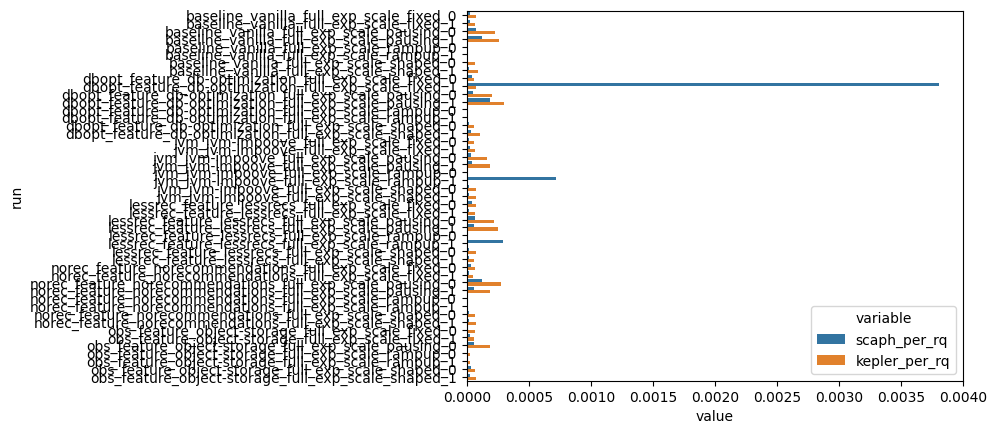

In [28]:
from matplotlib import pyplot as plt

merged_scaled = merged_stats.copy()
merged_scaled['kepler_per_rq'] /= 1_000 
melted = pd.melt(frame=merged_scaled, id_vars="run", value_vars=["scaph_per_rq", "kepler_per_rq"])
sns.barplot(data=melted, y="run", x="value", hue="variable")



In [29]:
merged_stats['scaph_per_rq'].mean() / merged_stats['kepler_per_rq'].mean()

merged_stats[['scaph_per_rq', 'kepler_per_rq']].corr()

,scaph_per_rq,kepler_per_rq
scaph_per_rq,1.000,-0.022
kepler_per_rq,-0.022,1.000
